In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#model

import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
from tensorflow.keras.applications import *

def squeeze_excite_block(inputs, ratio=8):
    init = inputs
    channel_axis = -1
    filters = init.shape[channel_axis]
    se_shape = (1, 1, filters)

    se = GlobalAveragePooling2D()(init)
    se = Reshape(se_shape)(se)
    se = Dense(filters // ratio, activation='relu', kernel_initializer='he_normal', use_bias=False)(se)
    se = Dense(filters, activation='sigmoid', kernel_initializer='he_normal', use_bias=False)(se)

    x = Multiply()([init, se])
    return x

def conv_block(inputs, filters):
    x = inputs

    x = Conv2D(filters, (3, 3), padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(filters, (3, 3), padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = squeeze_excite_block(x)

    return x

def encoder1(inputs):
    skip_connections = []

    model = VGG19(include_top=False, weights='imagenet', input_tensor=inputs)
    names = ["block1_conv2", "block2_conv2", "block3_conv4", "block4_conv4"]
    for name in names:
        skip_connections.append(model.get_layer(name).output)

    output = model.get_layer("block5_conv4").output
    return output, skip_connections

def decoder1(inputs, skip_connections):
    num_filters = [256, 128, 64, 32]
    skip_connections.reverse()
    x = inputs

    for i, f in enumerate(num_filters):
        x = UpSampling2D((2, 2), interpolation='bilinear')(x)
        x = Concatenate()([x, skip_connections[i]])
        x = conv_block(x, f)

    return x


def encoder2(inputs):
    num_filters = [32, 64, 128, 256]
    skip_connections = []
    x = inputs

    for i, f in enumerate(num_filters):
        x = conv_block(x, f)
        skip_connections.append(x)
        x = MaxPool2D((2, 2))(x)

    return x, skip_connections

def decoder2(inputs, skip_1, skip_2):
    num_filters = [256, 128, 64, 32]
    skip_2.reverse()
    x = inputs

    for i, f in enumerate(num_filters):
        x = UpSampling2D((2, 2), interpolation='bilinear')(x)
        x = Concatenate()([x, skip_1[i], skip_2[i]])
        x = conv_block(x, f)

    return x

def output_block(inputs):
    x = Conv2D(1, (1, 1), padding="same")(inputs)
    x = Activation('sigmoid')(x)
    return x

def Upsample(tensor, size):
    """Bilinear upsampling"""
    def _upsample(x, size):
        return tf.image.resize(images=x, size=size)
    return Lambda(lambda x: _upsample(x, size), output_shape=size)(tensor)

def ASPP(x, filter):
    shape = x.shape

    y1 = AveragePooling2D(pool_size=(shape[1], shape[2]))(x)
    y1 = Conv2D(filter, 1, padding="same")(y1)
    y1 = BatchNormalization()(y1)
    y1 = Activation("relu")(y1)
    y1 = UpSampling2D((shape[1], shape[2]), interpolation='bilinear')(y1)

    y2 = Conv2D(filter, 1, dilation_rate=1, padding="same", use_bias=False)(x)
    y2 = BatchNormalization()(y2)
    y2 = Activation("relu")(y2)

    y3 = Conv2D(filter, 3, dilation_rate=6, padding="same", use_bias=False)(x)
    y3 = BatchNormalization()(y3)
    y3 = Activation("relu")(y3)

    y4 = Conv2D(filter, 3, dilation_rate=12, padding="same", use_bias=False)(x)
    y4 = BatchNormalization()(y4)
    y4 = Activation("relu")(y4)

    y5 = Conv2D(filter, 3, dilation_rate=18, padding="same", use_bias=False)(x)
    y5 = BatchNormalization()(y5)
    y5 = Activation("relu")(y5)

    y = Concatenate()([y1, y2, y3, y4, y5])

    y = Conv2D(filter, 1, dilation_rate=1, padding="same", use_bias=False)(y)
    y = BatchNormalization()(y)
    y = Activation("relu")(y)

    return y
######################
#from tensorflow.keras.layers import Input, Conv2D
########
def build_model():
    size = 256
    inputs = Input((size, size, 3))

    x, skip_1 = encoder1(inputs)
    x = ASPP(x, 64)
    x = decoder1(x, skip_1)
    outputs1 = output_block(x)

    x = inputs * outputs1

    x, skip_2 = encoder2(x)
    x = ASPP(x, 64)
    x = decoder2(x, skip_1, skip_2)
    outputs2 = output_block(x)
    outputs = Concatenate()([outputs1, outputs2])
##############
    #outputs = Conv2D(filters=1, kernel_size=(1, 1), activation='sigmoid')(outputs)
##################
    model = Model(inputs, outputs)
    return model

if __name__ == "__main__":
    model = build_model()
    model.summary()

80134624/80134624 [==============================] - 4s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 256, 256, 64  1792        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv2 (Conv2D)          (None, 256, 256, 64  36928       ['block1_conv1[0][0]']           
                             

In [ ]:
    smooth = 1e-15
    def dice_coef(y_true, y_pred):
        y_true = tf.keras.layers.Flatten()(y_true)
        y_pred = tf.keras.layers.Flatten()(y_pred)
        intersection = tf.reduce_sum(y_true * y_pred)
        return (2. * intersection + smooth) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) + smooth)

    def dice_loss(y_true, y_pred):
        return 1.0 - dice_coef(y_true, y_pred)

    def iou(y_true, y_pred):
        def f(y_true, y_pred):
            intersection = (y_true * y_pred).sum()
            union = y_true.sum() + y_pred.sum() - intersection
            x = (intersection + smooth) / (union + smooth)
            x = x.astype(np.float32)
            return x
        return tf.numpy_function(f, [y_true, y_pred], tf.float32)

    def bce_dice_loss(y_true, y_pred):
        return binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)

    def focal_loss(y_true, y_pred):
        alpha=0.25
        gamma=2
        def focal_loss_with_logits(logits, targets, alpha, gamma, y_pred):
            weight_a = alpha * (1 - y_pred) ** gamma * targets
            weight_b = (1 - alpha) * y_pred ** gamma * (1 - targets)
            return (tf.math.log1p(tf.exp(-tf.abs(logits))) + tf.nn.relu(-logits)) * (weight_a + weight_b) + logits * weight_b

        y_pred = tf.clip_by_value(y_pred, tf.keras.backend.epsilon(), 1 - tf.keras.backend.epsilon())
        logits = tf.math.log(y_pred / (1 - y_pred))
        loss = focal_loss_with_logits(logits=logits, targets=y_true, alpha=alpha, gamma=gamma, y_pred=y_pred)
        # or reduce_sum and/or axis=-1
        return tf.reduce_mean(loss)

In [ ]:
import os
import numpy as np
import cv2
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, TensorBoard, EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Recall, Precision
from glob import glob
from tensorflow.keras.losses import binary_crossentropy
#from your_model_file import build_model

def read_image(path):
    x = cv2.imread(path, cv2.IMREAD_COLOR)
    x = cv2.resize(x, (256, 256))
    x = x.astype(np.float32)
    x = x / 255.0
    return x

def read_mask(path):
    x = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    x = cv2.resize(x, (256, 256))
    x = x.astype(np.float32)
    x = x / 255.0
    x = np.expand_dims(x, axis=-1)
    return x

# def preprocess_data(x, y):
#     x = read_image(x)
#     y = read_mask(y)
#     return x, y

# def preprocess_data(x, y):
#     x = read_image(x)
#     x = cv2.resize(x, (256, 256))
#     y = read_mask(y)
#     y = cv2.resize(y, (256, 256))
#     return x, y
def preprocess_data(x, y):
    #size=256
    x = read_image(x)
    #x = cv2.resize(x, (size, size))
    #x = x.astype(np.float32) / 255.0  # Normalize image
    y = read_mask(y)
    #y = cv2.resize(y, (size, size))
    #y = y.astype(np.float32) / 255.0  # Normalize mask
    #y = np.expand_dims(y, axis=-1)  # Add channel dimension
    y = np.concatenate([1 - y, y], axis=-1)  # Convert to binary representation
    return x, y


def load_data(train_path, valid_path):
    train_x = sorted(glob(os.path.join(train_path, "images", "*.png")))
    train_y = sorted(glob(os.path.join(train_path, "labels", "*.png")))
    valid_x = sorted(glob(os.path.join(valid_path, "images", "*.png")))
    valid_y = sorted(glob(os.path.join(valid_path, "labels", "*.png")))
    train_data = [preprocess_data(x, y) for x, y in zip(train_x, train_y)]
    valid_data = [preprocess_data(x, y) for x, y in zip(valid_x, valid_y)]
    return train_data, valid_data

if __name__ == "__main__":
    train_path = "/content/drive/MyDrive/Colab Notebooks/DFU/Foot Ulcer Segmentation Challenge/train"
    valid_path = "/content/drive/MyDrive/Colab Notebooks/DFU/Foot Ulcer Segmentation Challenge/validation"
    model_path = "/content/drive/MyDrive/Colab Notebooks/DFU/Foot Ulcer Segmentation Challenge/model.h5"



##########METRICS######################


###########################################################################
    batch_size = 10
    epochs = 20
    lr = 1e-4
    #shape = (256, 256, 3)

    model = build_model()
    metrics = [
        iou,dice_coef,focal_loss,bce_dice_loss,
        tf.keras.metrics.Recall(),
        tf.keras.metrics.Precision()
    ]

    train_data, valid_data = load_data(train_path, valid_path)
    train_x, train_y = zip(*train_data)
    valid_x, valid_y = zip(*valid_data)


    # train_dataset = tf.data.Dataset.from_tensor_slices((train_x, train_y))
    # train_dataset = train_dataset.batch(batch_size)
    # valid_dataset = tf.data.Dataset.from_tensor_slices((valid_x, valid_y))
    # valid_dataset = valid_dataset.batch(batch_size)

###2nd
    train_dataset = tf.data.Dataset.from_generator(lambda: train_data,
                                              output_signature=(tf.TensorSpec(shape=(256, 256, 3), dtype=tf.float32),
                                                                tf.TensorSpec(shape=(256, 256, 2), dtype=tf.float32)))

    train_dataset = train_dataset.batch(batch_size)

    valid_dataset = tf.data.Dataset.from_generator(lambda: valid_data,
                                              output_signature=(tf.TensorSpec(shape=(256, 256, 3), dtype=tf.float32),
                                                                tf.TensorSpec(shape=(256, 256, 2), dtype=tf.float32)))


    valid_dataset = valid_dataset.batch(batch_size)

    ###3rd
    #train_dataset = tf.data.Dataset.from_tensor_slices((train_data["train_x"], train_data["train_y"]))
    # train_dataset = train_dataset.map(preprocess_data)
    #train_dataset = train_dataset.batch(batch_size)

    #valid_dataset = tf.data.Dataset.from_tensor_slices((valid_data["valid_x"], valid_data["valid_y"]))
    # valid_dataset = valid_dataset.map(preprocess_data)
    #valid_dataset = valid_dataset.batch(batch_size)



    model.compile(loss=dice_loss, optimizer=Adam(lr), metrics=metrics)

    callbacks = [
        ModelCheckpoint(model_path),
        ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=epochs*.3),
        TensorBoard(),
        EarlyStopping(monitor='val_loss', patience=epochs*.3, restore_best_weights=False)
    ]


    train_steps = len(train_x)//batch_size
    valid_steps = len(valid_x)//batch_size
    train_dataset = train_dataset.repeat()
    # if len(train_x) % batch_size != 0:
    #     train_steps += 1
    # if len(valid_x) % batch_size != 0:
    #     valid_steps += 1



In [ ]:
history= model.fit(train_dataset,
        validation_data=valid_dataset,
        epochs=epochs,
        steps_per_epoch=train_steps,
        validation_steps=valid_steps,
        callbacks=callbacks)

Epoch 1/20
81/81 [==============================] - 77s 951ms/step - loss: 0.1855 - iou: 0.6870 - dice_coef: 0.8145 - focal_loss: 0.0050 - bce_dice_loss: 0.3857 - recall: 0.9963 - precision: 0.9968 - val_loss: 0.2048 - val_iou: 0.6601 - val_dice_coef: 0.7952 - val_focal_loss: 0.0050 - val_bce_dice_loss: 0.4283 - val_recall: 0.9956 - val_precision: 0.9979 - lr: 1.0000e-04
Epoch 2/20
81/81 [==============================] - 73s 907ms/step - loss: 0.1739 - iou: 0.7037 - dice_coef: 0.8261 - focal_loss: 0.0045 - bce_dice_loss: 0.3604 - recall: 0.9966 - precision: 0.9970 - val_loss: 0.1827 - val_iou: 0.6911 - val_dice_coef: 0.8173 - val_focal_loss: 0.0039 - val_bce_dice_loss: 0.3785 - val_recall: 0.9966 - val_precision: 0.9975 - lr: 1.0000e-04
Epoch 3/20
81/81 [==============================] - 77s 947ms/step - loss: 0.1628 - iou: 0.7200 - dice_coef: 0.8372 - focal_loss: 0.0040 - bce_dice_loss: 0.3363 - recall: 0.9969 - precision: 0.9973 - val_loss: 0.1631 - val_iou: 0.7195 - val_dice_coef: 

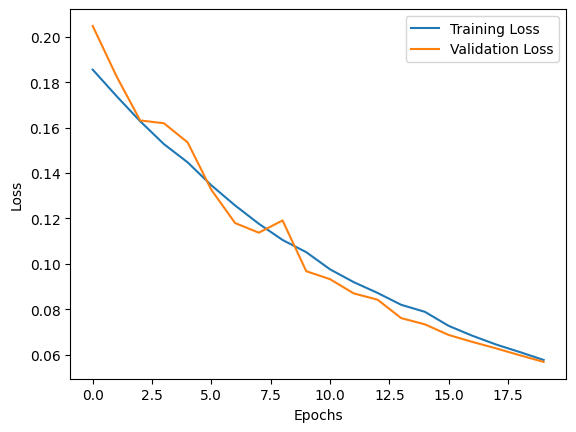

In [ ]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

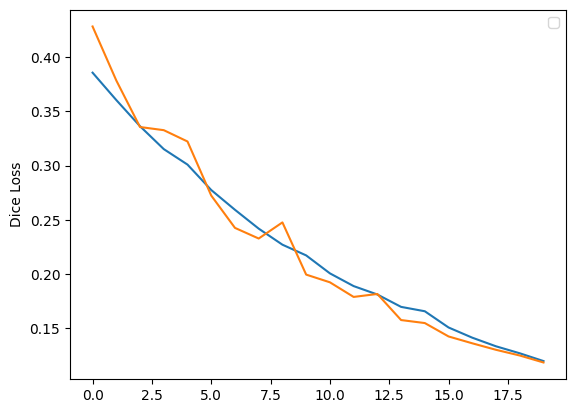

In [ ]:
plt.plot(history.history["bce_dice_loss"])
plt.plot(history.history["val_bce_dice_loss"])
plt.ylabel("Dice Loss")
plt.legend()
plt.show()

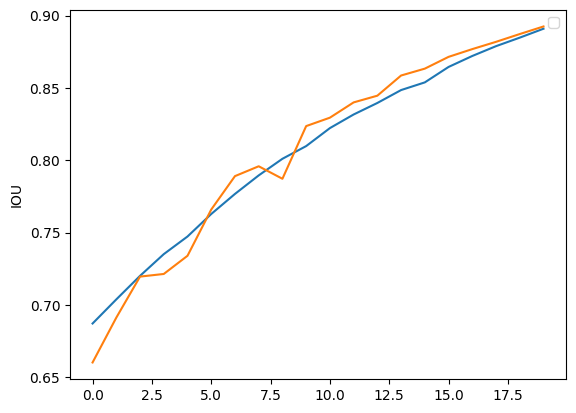

In [ ]:
plt.plot(history.history["iou"])
plt.plot(history.history["val_iou"])
plt.ylabel("IOU")
plt.legend()
plt.show()

<Axes: >

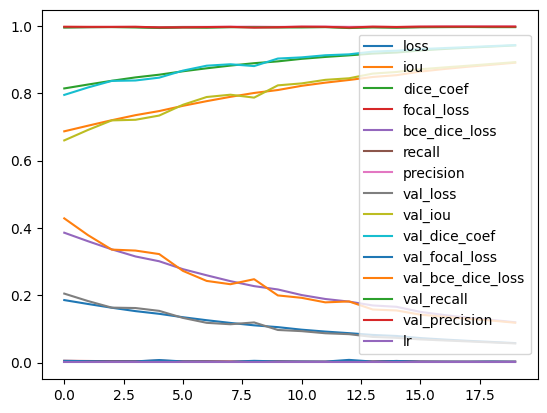

In [ ]:
import pandas as pd
Dict_Summary = pd.DataFrame(history.history)
Dict_Summary.plot()

In [ ]:
###########
import cv2
import numpy as np
from google.colab.patches import cv2_imshow

def preprocess_test_image(image_path):
    image = cv2.imread(image_path, cv2.IMREAD_COLOR)
    image = cv2.resize(image, (256, 256))
    image = image.astype(np.float32) / 255.0
    return image

def postprocess_mask(mask):
    mask = np.argmax(mask, axis=-1)

    #############
    mask=cv2.resize(mask,(256,256))
    mask = np.squeeze(mask)
    mask= mask>0.5
    #mask = [mask, mask]
    #mask = np.transpose(mask, (1, 2, 0))

    ############
    mask = mask.astype(np.uint8) * 255
    return mask

def predict_test_images(model, test_image_paths):
    predicted_masks = []
    for image_path in test_image_paths:
        image = preprocess_test_image(image_path)
        mask = model.predict(np.expand_dims(image, axis=0))[0]
        mask = postprocess_mask(mask)
        predicted_masks.append(mask)
    return predicted_masks

# Specify the path to your test images
test_path = "/content/drive/MyDrive/Colab Notebooks/DFU/Foot Ulcer Segmentation Challenge/test"

test_image_paths = sorted(glob(os.path.join(test_path, "images", "*.png")))

# Load the trained model
model_path = "/content/drive/MyDrive/Colab Notebooks/DFU/Foot Ulcer Segmentation Challenge/model.h5"
model = tf.keras.models.load_model(model_path, custom_objects={'dice_loss':dice_loss,'focal_loss':focal_loss,'bce_dice_loss':bce_dice_loss,'dice_coef': dice_coef, 'iou': iou})

# Generate predicted masks for test images
predicted_masks = predict_test_images(model, test_image_paths)

# Display the predicted masks
for i, mask in enumerate(predicted_masks):
    image_path = test_image_paths[i]
    image = cv2.imread(image_path)
    print("Test Image:")
    cv2_imshow(image)
    print("Predicted Mask:")
    cv2_imshow(mask)

In [ ]:
##########validation folder#########
import cv2
import numpy as np
from glob import glob
import os
from google.colab.patches import cv2_imshow
import tensorflow as tf

def preprocess_test_image(image_path):
    image = cv2.imread(image_path, cv2.IMREAD_COLOR)
    image = cv2.resize(image, (256, 256))
    image = image.astype(np.float32) / 255.0
    return image

def preprocess_test_mask(mask_path):
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    mask = cv2.resize(mask, (256, 256))
    mask = mask.astype(np.float32) / 255.0
    mask = np.expand_dims(mask, axis=-1)
    return mask

def postprocess_mask(mask):
    #mask = cv2.resize(mask, (256, 256))
    mask=mask>0.5

    mask = np.argmax(mask, axis=-1)
    mask = np.squeeze(mask)
    mask = mask.astype(np.uint8) * 255
    mask = np.concatenate([1 - mask, mask], axis=-1)
    return mask

def predict_test_images(model, test_image_paths, test_mask_paths):
    predicted_masks = []
    for image_path, mask_path in zip(test_image_paths, test_mask_paths):
        image = preprocess_test_image(image_path)
        mask = preprocess_test_mask(mask_path)
        predicted_mask = model.predict(np.expand_dims(image, axis=0))[0]
        predicted_mask = postprocess_mask(predicted_mask)
        predicted_masks.append(predicted_mask)
    return predicted_masks

# Specify the path to your test folder containing images and masks
test_folder = "/content/drive/MyDrive/Colab Notebooks/DFU/Foot Ulcer Segmentation Challenge/validation"

test_image_paths = sorted(glob(os.path.join(test_folder, "images", "*.png")))
test_mask_paths = sorted(glob(os.path.join(test_folder, "labels", "*.png")))

# Load the trained model
model_path = "/content/drive/MyDrive/Foot Ulcer Segmentation Challenge/model.h5"
model = tf.keras.models.load_model(model_path, custom_objects={'dice_loss': dice_loss, 'focal_loss': focal_loss, 'bce_dice_loss': bce_dice_loss, 'dice_coef': dice_coef, 'iou': iou})

# Generate predicted masks for test images
predicted_masks = predict_test_images(model, test_image_paths, test_mask_paths)

# Display the test images, corresponding masks, and predicted masks
for i in range(len(test_image_paths)):
    image_path = test_image_paths[i]
    mask_path = test_mask_paths[i]
    predicted_mask = predicted_masks[i]

    test_image = cv2.imread(image_path)
    test_mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

    print("Test Image:")
    cv2_imshow(test_image)
    print("Corresponding Mask:")
    cv2_imshow(test_mask)
    print("Predicted Mask:")
    cv2_imshow(predicted_mask)